# Associative memory via sparse recovery

In [56]:
import numpy as np
import numpy.linalg as la
import numpy.random as rand
import scipy.fftpack as fft
import scipy.stats as stat
import matplotlib.pyplot as plt
import cv2 as cv
import warnings as warn
from keras import backend as K
from keras import activations, constraints, regularizers, initializers
from keras.engine.base_layer import InputSpec, Layer
from keras.legacy import interfaces
from keras.datasets import mnist
from tqdm import tnrange, tqdm_notebook as tqdm
from jupyterthemes import jtplot

In [14]:
jtplot.reset()
plt.style.use("bmh")
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["text.latex.preamble"] = [r"\usepackage{physics}"]

In [43]:
def shannonEntropy2D(img, base=2):       
    img_grad = np.asarray(np.gradient(img)).T
    img_grad /= img_grad.max()
    img_grad = np.uint8(img_grad * 255)
    hist = np.squeeze(cv.calcHist([img_grad], [0, 1], None, [256, 256], [0, 256, 0, 256]))/img_grad.size
    with warn.catch_warnings():
        warn.simplefilter('ignore')
        if base == 2:
            log = np.log2
        elif base == 10:
            log = np.log10
        elif base == 'e':
            log = np.log
        H = -1/2 * np.nansum(hist*log(hist))
    return H

In [3]:
class Bipartite(Layer):
    @interfaces.legacy_dense_support
    def __init__(self, units,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(Bipartite, self).__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(min_ndim=2)
        self.supports_masking = True

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    def call(self, inputs):
        output = K.dot(inputs, self.kernel)
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')
        if self.activation is not None:
            output = self.activation(output)
        return output

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        assert input_shape[-1]
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return tuple(output_shape)

    def get_config(self):
        config = {
            'units': self.units,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer':
                regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(Bipartite, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [146]:
class Hopfield:
    def __init__(self, units,
                 epochs,
                 activation='threshold',
                 loss='energy',
                 lr=0.01,
                 eps=0.1,
                 weight_initializer='random_uniform',
                 random_seed=401,
                 threshold=0):
        rand.seed(random_seed)
        self.units = units
        self.epochs = epochs
        self.activation = activation
        self.loss = loss
        self.lr = lr
        self.eps = eps
        self.weight_initializer = weight_initializer
        self.threshold = threshold
        
        if self.weight_initializer == 'random_uniform':
            self.W = rand.random((self.units, self.units))
        elif self.weight_initializer == 'random_normal':
            self.W = rand.normal((0, 1, (self.units, self.units)))
        else:
            raise NotImplementedError

        if self.activation == 'step':
            self.g = lambda a: 1 if a >= 0 else -1
        elif self.activation == 'threshold':
            self.g = lambda a: np.outer(a, a)
        elif self.activation == 'sigmoid':
            self.g = lambda a: 1/(1 + np.exp(-a))
        elif self.activation == 'softmax':
            self.g = lambda a: np.exp(a)/np.sum(np.exp(a))
        elif self.activation == 'tanh':
            self.g = lambda a: np.tanh(a)
        else:
            raise NotImplementedError
            
        if self.loss == 'sse':
            self.l = lambda y_true, y_pred: (y_true - y_pred)**2
        elif self.loss == 'energy':
            self.l = lambda s: -1/2 * s.dot(self.W).dot(s) + np.sum(s - self.threshold)
        else:
            raise NotImplementedError
            
    def train(self, X):
        self.rho = np.sum([np.sum(x) for x in X])/(len(X)*self.units)
        for count in tnrange(self.epochs, desc='Epoch'):
            for x in X:
                t = x - self.rho
                dW = np.outer(t, t)
                self.W += dW
            self.W -= np.diag(np.diag(self.W))
            self.W /= len(X)
            
    def predict(self, X, num_iter=20):
        predicted = []
        for i in tnrange(len(X), desc='Predict'):
            predicted.append(self._run(X.copy(), num_iter))
        self.predicted = np.asarray(predicted)
        
    def _run(self, init_s, num_iter):
        s = init_s
        e = self.l(s)
        for i in range(num_iter):
            for j in range(100):
                idx = rand.randint(self.units)
                s[idx] = np.sign(self.W[idx].T.dot(s) - self.threshold)
            e_new = self.l(s)
            if e == e_new:
                return s
            e = e_new
        return s

In [10]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [85]:
X = np.zeros((10, 28, 28))
for i in range(10):
    for j in range(len(x_train)):
        if y_train[j] == i:
            X[i] = x_train[j]
            X[i][X[i] <= 127] = -1
            X[i][X[i] > 127] = 1

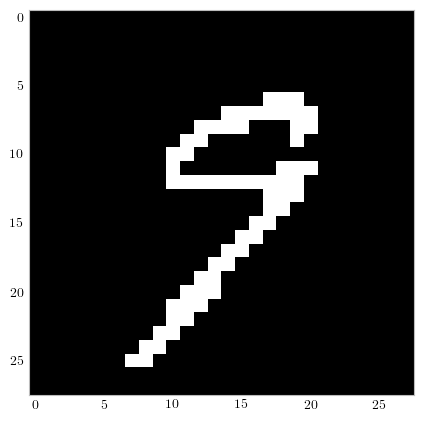

In [86]:
plt.imshow(X[9], 'gray')
plt.grid(0)
plt.show()

In [140]:
hop = Hopfield(units=28**2,
               epochs=300)
hop.train(X[0].ravel())

In [141]:
hop.predict(X[0].ravel())

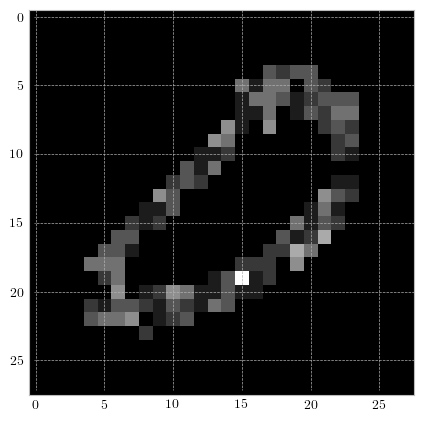

In [149]:
plt.imshow(hop.predicted.sum(axis=0).reshape(28, 28), 'gray')
plt.show()